In [ ]:
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade pandas

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Preparação dos dados

Código das partes 2, 3 e 4.

In [2]:
# Mapa
rj = gpd.read_file('/content/drive/MyDrive/Programacao/GeoPandas/Mapas/RJ/33MUE250GC_SIR.shp')
rj = rj[rj['NM_MUNICIP'] == 'RIO DE JANEIRO']

# Dados Imóveis
df_dados_imoveis = pd.read_table('/content/drive/MyDrive/Programacao/GeoPandas/Dados/dados.txt')
geometry = [Point(localizacao) for localizacao in zip(df_dados_imoveis.Longitude, df_dados_imoveis.Latitude)] # lista de Points com as localizações
crs = {'proj' : 'latlong',
       'ellps': 'WGS84',
       'datum' : 'WGS84',
       'no_defs' : True}
gdf_dados_imoveis = gpd.GeoDataFrame(df_dados_imoveis, crs = crs, geometry = geometry)

# Dados 
metro = gpd.read_file('/content/drive/MyDrive/Programacao/GeoPandas/Dados/Estacoes_Metro.geojson')
trem = gpd.read_file('/content/drive/MyDrive/Programacao/GeoPandas/Dados/Estacoes_Trem.geojson')
brt = gpd.read_file('/content/drive/MyDrive/Programacao/GeoPandas/Dados/Estacoes_BRT.geojson')

# set do crs
rj = rj.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
gdf_dados_imoveis = gdf_dados_imoveis.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
metro = metro.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
trem = trem.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
brt = brt.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')

# Pontos dentro da cidade
esta_dentro = gdf_dados_imoveis['geometry'].within(rj.iloc[0].geometry)
gdf_dados_imoveis = gdf_dados_imoveis[esta_dentro]

esta_dentro = trem['geometry'].within(rj.iloc[0].geometry) # Seleciona apenas as estações dentro do município
trem = trem[esta_dentro]

# Distância para as estações
gdf_dados_imoveis['Dist_Metro'] = gdf_dados_imoveis['geometry'].apply(lambda x: metro.distance(x).min())
gdf_dados_imoveis['Dist_Trem'] = gdf_dados_imoveis['geometry'].apply(lambda x: trem.distance(x).min())
gdf_dados_imoveis['Dist_BRT'] = gdf_dados_imoveis['geometry'].apply(lambda x: brt.distance(x).min())

# Distância até os meios de transporte
transporte = pd.concat([metro.geometry, trem.geometry, brt.geometry], ignore_index=True)
gdf_dados_imoveis['Dist_Transporte'] = gdf_dados_imoveis['geometry'].apply(lambda x: transporte.distance(x).min())

In [ ]:
gdf_dados_imoveis.head()

,Area,Bairro,Cidade,Endereco,Estado,Latitude,Longitude,Quartos,Suites,Vagas,Tipo,Transacao,Valor,geometry,Dist_Metro,Dist_Trem,Dist_BRT,Dist_Transporte
0,138,Recreio dos Bandeirantes,Rio de Janeiro,Rua Vicente Scofano,RJ,-23.016455,-43.462946,3,1,3,Apartamento,Venda,1095000,POINT (657.514 7453.832),15.622939,15.627477,0.443193,0.443193
1,133,Freguesia (Jacarepaguá),Rio de Janeiro,Rua Potiguara,RJ,-22.943199,-43.336911,3,1,2,Apartamento,Venda,650000,POINT (670.524 7461.803),7.530741,6.266952,3.642787,3.642787
2,46,Pilares,Rio de Janeiro,Rua Professor Carneiro Felipe,RJ,-22.873849,-43.300517,1,0,0,Apartamento,Venda,150000,POINT (674.345 7469.440),0.736973,0.641470,2.657083,0.641470
3,65,Barra da Tijuca,Rio de Janeiro,Avenida Salvador Allende,RJ,-22.984787,-43.412703,2,1,1,Apartamento,Venda,430000,POINT (662.701 7457.284),10.718039,12.303554,0.422370,0.422370
5,260,Recreio dos Bandeirantes,Rio de Janeiro,Rua Desembargador Paulo Alonso,RJ,-23.018927,-43.477505,3,1,2,Apartamento,Venda,1160000,POINT (656.019 7453.574),17.131159,15.241645,0.214605,0.214605


# Distância até a praia

Cálculo de distância entre um imóvel e uma estação:

- Distância entre dois pontos: Imóvel e Estação;

Cálculo de distância entre um imóvel e a praia:

- Distância entre um ponto (imóvel) e um polígono (praia).

In [3]:
praias = gpd.read_file('/content/drive/MyDrive/Programacao/GeoPandas/Dados/Cobertura_Vegetal_e_Uso_da_Terra_2016.geojson')
praias = praias.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
praias.head(1)

,Sigla,ANO,legenda,ShapeSTArea,ShapeSTLength,OBJECTID,GRUPO,CLASSE,FORMACOES,ESTAGIO_SUCESSIONAL,"SMAC""RIO\02497196""Mapeamento_CoberturaArea",geometry
0,Con,2016-01-01T00:00:00+00:00,Corpos d’água continentais,8684.890625,441.128326,19870,Outros,Corpos d’água continentais,,,8684.889153,"POLYGON ((646.900 7448.811, 646.889 7448.795, ..."


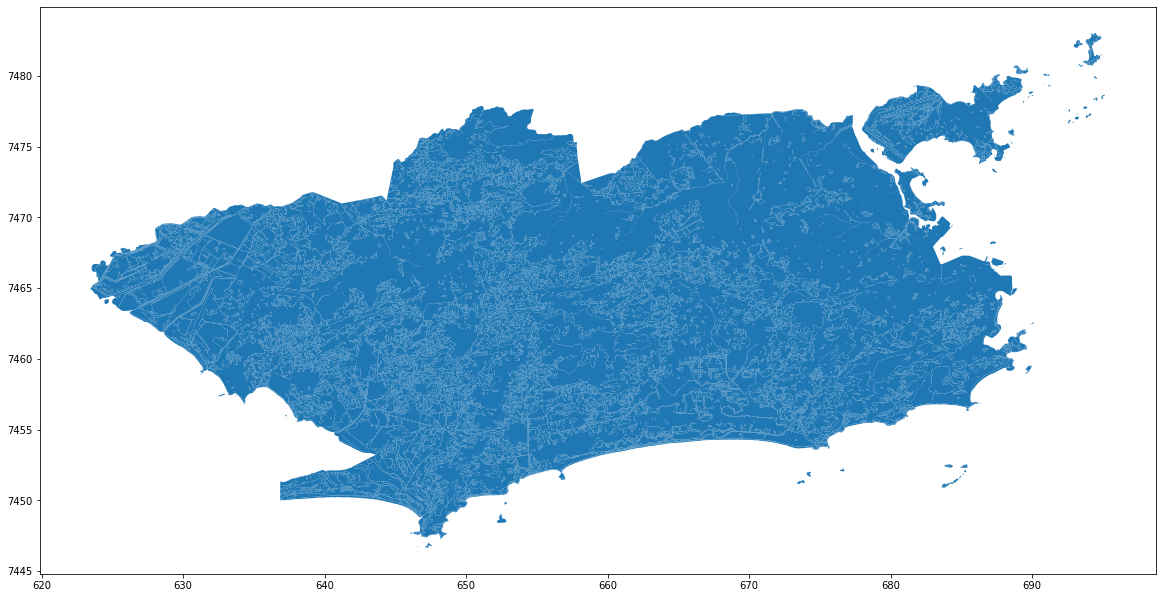

In [ ]:
praias.plot(figsize=(20,20))

Extraindo apenas as praias:

In [ ]:
praias['legenda'].value_counts()

Vegetação arbórea não florestal                                     3495
Vegetação gramíneo-lenhosa                                          2022
Floresta Ombrófila Densa, Estágio Inicial                            643
Áreas Urbanas                                                        639
Afloramento Rochoso                                                  474
Uso agrícola, Lavoura Permanente                                     445
Floresta Ombrófila Densa, Estágio Médio                              414
Corpos d’água continentais                                           388
Reflorestamento                                                      252
Formação Pioneira com influência flúvio-lacustre, Brejo herbáceo     210
Uso agrícola, Lavoura Temporária                                     164
Formação Pioneira com influência flúvio-marinha, Manguezal           161
Solo exposto                                                         152
Formação Pioneira com influência flúvio-marinha, Ca

In [4]:
praias = praias[praias['legenda']=='Praia']
praias.head(1)

,Sigla,ANO,legenda,ShapeSTArea,ShapeSTLength,OBJECTID,GRUPO,CLASSE,FORMACOES,ESTAGIO_SUCESSIONAL,"SMAC""RIO\02497196""Mapeamento_CoberturaArea",geometry
21,P,2016-01-01T00:00:00+00:00,Praia,3042.035156,257.566546,19891,Outros,Praia,,,3042.036027,"POLYGON ((646.841 7448.837, 646.797 7448.877, ..."


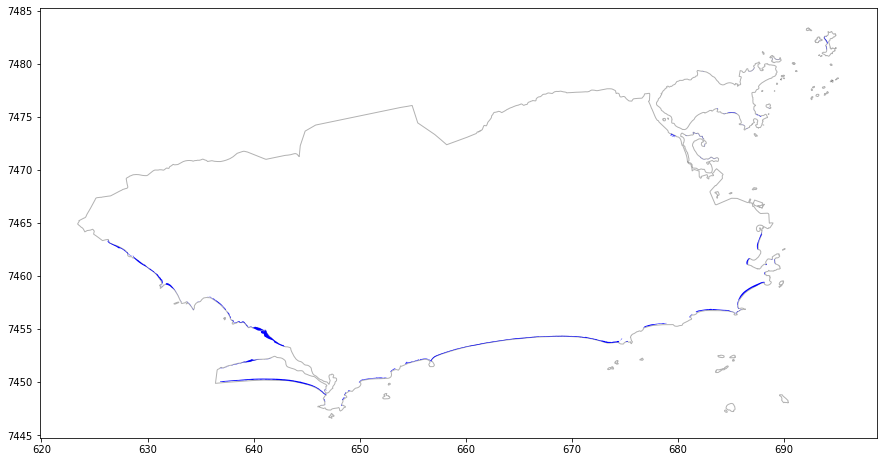

In [ ]:
# Plot das praias
base = rj.plot(color='white', edgecolor='black', figsize=(15,15), alpha = 0.3)
praias.plot(ax = base, figsize=(15,15), color='blue')

Distância até a praia:

In [5]:
gdf_dados_imoveis['Dist_Praia'] = gdf_dados_imoveis['geometry'].apply(lambda x: praias.distance(x).min())
gdf_dados_imoveis.head()

,Area,Bairro,Cidade,Endereco,Estado,Latitude,Longitude,Quartos,Suites,Vagas,Tipo,Transacao,Valor,geometry,Dist_Metro,Dist_Trem,Dist_BRT,Dist_Transporte,Dist_Praia
0,138,Recreio dos Bandeirantes,Rio de Janeiro,Rua Vicente Scofano,RJ,-23.016455,-43.462946,3,1,3,Apartamento,Venda,1095000,POINT (657.514 7453.832),15.622939,15.627477,0.443193,0.443193,1.143453
1,133,Freguesia (Jacarepaguá),Rio de Janeiro,Rua Potiguara,RJ,-22.943199,-43.336911,3,1,2,Apartamento,Venda,650000,POINT (670.524 7461.803),7.530741,6.266952,3.642787,3.642787,7.478698
2,46,Pilares,Rio de Janeiro,Rua Professor Carneiro Felipe,RJ,-22.873849,-43.300517,1,0,0,Apartamento,Venda,150000,POINT (674.345 7469.440),0.736973,0.641470,2.657083,0.641470,6.240694
3,65,Barra da Tijuca,Rio de Janeiro,Avenida Salvador Allende,RJ,-22.984787,-43.412703,2,1,1,Apartamento,Venda,430000,POINT (662.701 7457.284),10.718039,12.303554,0.422370,0.422370,3.404589
5,260,Recreio dos Bandeirantes,Rio de Janeiro,Rua Desembargador Paulo Alonso,RJ,-23.018927,-43.477505,3,1,2,Apartamento,Venda,1160000,POINT (656.019 7453.574),17.131159,15.241645,0.214605,0.214605,1.369015


In [ ]:
# Correlação do valor do imóvel em relação a distância até a praia
corr_praia = gdf_dados_imoveis['Valor'].corr(gdf_dados_imoveis['Dist_Praia'])
corr_metro = gdf_dados_imoveis['Valor'].corr(gdf_dados_imoveis['Dist_Metro'])
corr_trem = gdf_dados_imoveis['Valor'].corr(gdf_dados_imoveis['Dist_Trem'])
corr_brt = gdf_dados_imoveis['Valor'].corr(gdf_dados_imoveis['Dist_BRT'])
corr_transp = gdf_dados_imoveis['Valor'].corr(gdf_dados_imoveis['Dist_Transporte'])

print('Correlação Preço x Dist. Praia:', corr_praia)
print('Correlação Preço x Dist. Metro:', corr_metro)
print('Correlação Preço x Dist. Trem:', corr_trem)
print('Correlação Preço x Dist. BRT:', corr_brt)
print('Correlação Preço x Dist. Transporte:', corr_transp)

Correlação Preço x Dist. Praia: -0.3615189752936541
Correlação Preço x Dist. Metro: -0.19564083161686885
Correlação Preço x Dist. Trem: 0.19161785331482598
Correlação Preço x Dist. BRT: 0.3443413649750603
Correlação Preço x Dist. Transporte: -0.10365283748645952


A correlação mais acentuada é em relação a distância até a praia (-0.36). Sendo quanto maior a distância até a praia, menor o valor do imóvel. Sendo a distância até uma estação de metrô a segunda maior correlação.

# Salvando os dados modificados

In [11]:
import os

dir = '/content/drive/MyDrive/Programacao/GeoPandas/Dados/Dados_Modificados'
if not os.path.exists(dir):
    os.makedirs(dir)

gdf_dados_imoveis.to_file(dir + '/Imoveis') # Imóveis com distâncias para estações e praias
rj.to_file(dir + '/RJ_Municipio') # Município do RJ
metro.to_file(dir + '/Metro') # Metro com CRS atualizado
trem.to_file(dir + '/Trem') # Trem com CRS atualizado
brt.to_file(dir + '/BRT') # BRT com CRS atualizado

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  # This is added back by InteractiveShellApp.init_path()
